# Bootstrap

In this notebook I will cover the bootstrap method. A toy regression dataset will be created using the make_regression function available through scikit-learn.

In [1]:
## imports ##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [2]:
## function to generate bootstrap datasets ##
def make_bootstraps(data,n_bootstraps=100):
    #initialize output dictionary & unique value count
    dc   = {}
    unip = 0
    #get sample size
    b_size = data.shape[0]
    #get list of row indexes
    idx = [i for i in range(b_size)]
    #loop through the required number of bootstraps
    for b in range(n_bootstraps):
        #obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=b_size)
        b_samp = data[sidx,:]
        #compute number of unique values contained in the bootstrap sample
        unip  += len(set(sidx))
        #obtain out-of-bag samples for the current b
        oidx   = list(set(idx) - set(sidx))
        o_samp = np.array([])
        if oidx:
            o_samp = data[oidx,:]
        #store results
        dc['boot_'+str(b)] = {'boot':b_samp,'test':o_samp}
    #state the mean number of unique values in the bootstraps
    print('Mean number of unique values in each bootstrap: {:.2f}'.format(unip/n_bootstraps))
    #return the bootstrap results
    return(dc)

## function determining the dependence on training size for our model ##
def error_by_trainsize(train,test,train_size,iters=10):
    #initialize model
    lr    = LinearRegression()
    maes  = np.array([])
    mses  = np.array([])
    #get list of row indexes
    idx = [i for i in range(train.shape[0])]
    #loop over each training size
    for ts in train_size:
        #initialize error metrics
        mae = 0
        mse = 0
        #for each training size, I will repeat the calculation iters times
        for j in range(iters):
            #obtain training samples without replacement
            sidx     = np.random.choice(idx,replace=False,size=ts)
            trainset = np.copy(train[sidx,:])
            #fit a linear regression model to the training set
            lr.fit(trainset[:,0].reshape(-1,1),trainset[:,1].reshape(-1,1))
            #generate predictions & calculate error metrics
            yp  = lr.predict(test[:,0].reshape(-1,1))
            mae += mean_absolute_error(test[:,1],yp)
            mse += mean_squared_error(test[:,1],yp) 
        #store the mean error metrics over all repetitions
        mae = np.array([mae/iters])
        mse = np.array([mse/iters])
        maes = np.concatenate((maes,mae))
        mses = np.concatenate((mses,mse))
    #return error metrics
    return(maes,mses)

### Synthetic Regression Dataset

Let's look at a synthetic regression dataset using the scikit-learn API. These data will consist of 5000 samples with 1 input, and 1 output feature. The noise on the output variable follows a gaussian with a standard-deviation of 25.0. The y-intercept is set as 1.0.

In [3]:
## build a synthetic regression dataset ##
x,y,coef = make_regression(n_samples=5000,n_features=1,n_targets=1,coef=True,noise=25.0,bias=1.0,random_state=42)

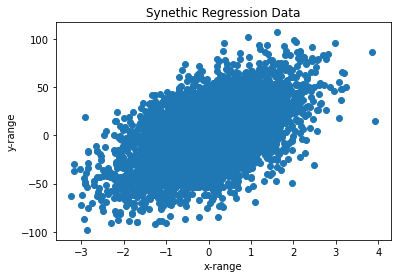

In [4]:
## plot regression data ##
plt.scatter(x,y)
plt.xlabel('x-range')
plt.ylabel('y-range')
plt.title('Synethic Regression Data')
plt.show()

### Training Size vs Performance

As a first step, let's take a look at how the performance of the model is affected by the training set size of unique data points?

In [5]:
## extract out a small test set to measure performance ##
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.1, random_state=42)

In [6]:
## define a set of training set sizes to choose from ##
train_size = [10,100,500,1000,1500,2000,2500,3000,3500,4000]

In [7]:
## package the data ##
train = np.concatenate((xtrain,ytrain.reshape(-1,1)),axis=1)
test  = np.concatenate((xtest,ytest.reshape(-1,1)),axis=1)

In [8]:
## for each training set size, fit a model and calculate the error ##
maes,mses = error_by_trainsize(train,test,train_size)

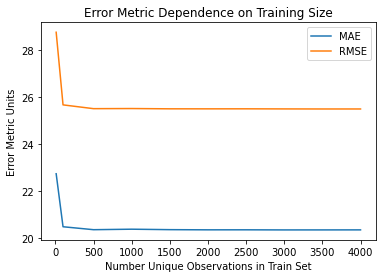

In [9]:
## plot the error curves ##
plt.plot(train_size,maes)
plt.plot(train_size,np.sqrt(mses))
plt.title('Error Metric Dependence on Training Size')
plt.xlabel('Number Unique Observations in Train Set')
plt.ylabel('Error Metric Units')
plt.legend(['MAE','RMSE'])
plt.show()

The plot above indicates that the linear regression model reaches an optimium with a training set containing approximately 500 unique samples. It's important to keep this in mind during the application of the bootstrap method.

### Bootstrap Analysis

Let's now proceed with carrying out a bootstrap analysis of these data:

In [10]:
## package the data ##
data = np.concatenate((x,y.reshape(-1,1)),axis=1)

In [11]:
## generate bootstrap samples ##
dcBoot = make_bootstraps(data)

Mean number of unique values in each bootstrap: 3158.06


The number of unique values per bootstrap is significantly higher than the limit of ~500 determined earlier. We can therefore determine that bias will not be a problem during this analysis.

In [12]:
## iterate through each bootstrap sample, and compute the desired statistics ##
#initialize storage variables & model
coefs = np.array([])
intrs = np.array([])
maes  = np.array([])
mses  = np.array([])
lr    = LinearRegression()
#loop through each bootstrap sample
for b in dcBoot:
    #fit a linear regression model to the current sample
    lr.fit(dcBoot[b]['boot'][:,0].reshape(-1, 1),dcBoot[b]['boot'][:,1].reshape(-1, 1))
    #store model parameters
    coefs = np.concatenate((coefs,lr.coef_.flatten()))
    intrs = np.concatenate((intrs,lr.intercept_.flatten()))
    #compute the predictions on the out-of-bag test set & compute metrics
    if dcBoot[b]['test'].size:
        yp  = lr.predict(dcBoot[b]['test'][:,0].reshape(-1, 1))
        mae = mean_absolute_error(dcBoot[b]['test'][:,1],yp)
        mse = mean_squared_error(dcBoot[b]['test'][:,1],yp)   
        #store the error metrics
        maes = np.concatenate((maes,mae.flatten()))
        mses = np.concatenate((mses,mse.flatten()))

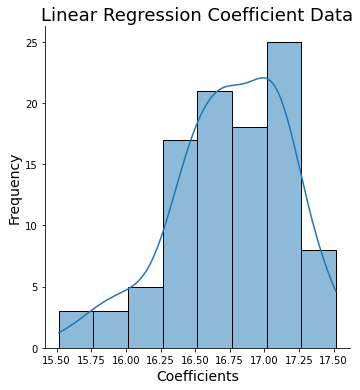

In [13]:
## plot histogram of regression coefficients ##
sns.displot(coefs, kde=True)
plt.title('Linear Regression Coefficient Data', fontsize=18)
plt.xlabel('Coefficients', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [14]:
## Compute Statistics on Model Coefficient ##
print('Expected value: ',np.mean(coefs))
print('Standard Error: ',np.std(coefs))
print('99% Confidence Interval for regression coefficient: {',
      np.percentile(coefs,0.5),'-',np.percentile(coefs,99.5),'}')

Expected value:  16.75268299385114
Standard Error:  0.41459010245722283
99% Confidence Interval for regression coefficient: { 15.626958562551083 - 17.502946810603436 }


In [15]:
## what is the true regression coefficient? ##
print('True regression coefficient: ',str(coef))

True regression coefficient:  16.82365791084919


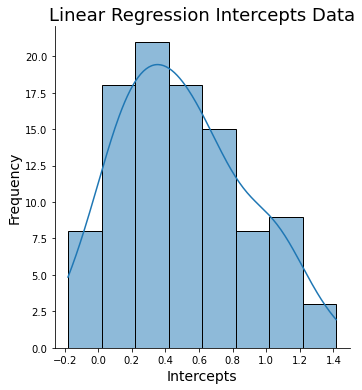

In [16]:
## plot histogram of regression intercepts ##
sns.displot(intrs, kde=True)
plt.title('Linear Regression Intercepts Data', fontsize=18)
plt.xlabel('Intercepts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [17]:
## Compute Statistics on Model Intercept ##
print('Expected value: ',np.mean(intrs))
print('Standard Error: ',np.std(intrs))
print('99% Confidence Interval for regression intercept: {',
      np.percentile(intrs,0.5),'-',np.percentile(intrs,99.5),'}')

Expected value:  0.49859246927978473
Standard Error:  0.3724011736182721
99% Confidence Interval for regression intercept: { -0.17311716146322081 - 1.353356985002588 }


We can see that the true regression model parameters (16.82,1.0) are nicely contained within the 99% confidence intervals calculated above. The width of the confidence intervals also gives us a sense for how precise the model parameter values given by the optimisation procedure are.

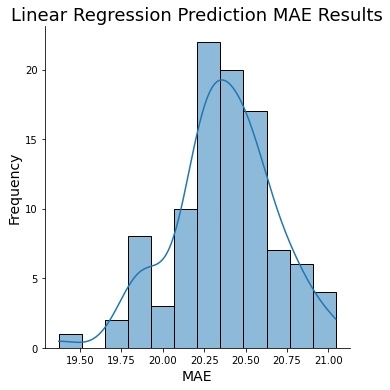

In [18]:
## plot histogram of mae on predictions ##
sns.displot(maes, kde=True)
plt.title('Linear Regression Prediction MAE Results', fontsize=18)
plt.xlabel('MAE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [19]:
## 99% CI of MAE results ##
print('99% Confidence Interval for Prediction MAE results: {',
      np.percentile(maes,0.5),'-',np.percentile(maes,99.5),'}')

99% Confidence Interval for Prediction MAE results: { 19.565403852749235 - 21.04264922918013 }


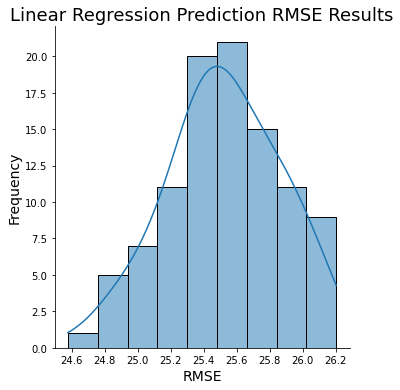

In [20]:
## plot histogram of rmse on predictions ##
sns.displot(np.sqrt(mses), kde=True)
plt.title('Linear Regression Prediction RMSE Results', fontsize=18)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [21]:
## 99% CI of RMSE results ##
print('99% Confidence Interval for Prediction RMSE results: {',
      np.percentile(np.sqrt(mses),0.5),'-',np.percentile(np.sqrt(mses),99.5),'}')

99% Confidence Interval for Prediction RMSE results: { 24.66787645445871 - 26.195319184718425 }


Using the results of the bootstrap analysis permits us to determine confidence intervals for prediction error metrics of our choice. These results indicate the level of spread in the prediction error we can expect using linear regression on our dataset. Note that the input noise level falls within the 99% CI for the RMSE.

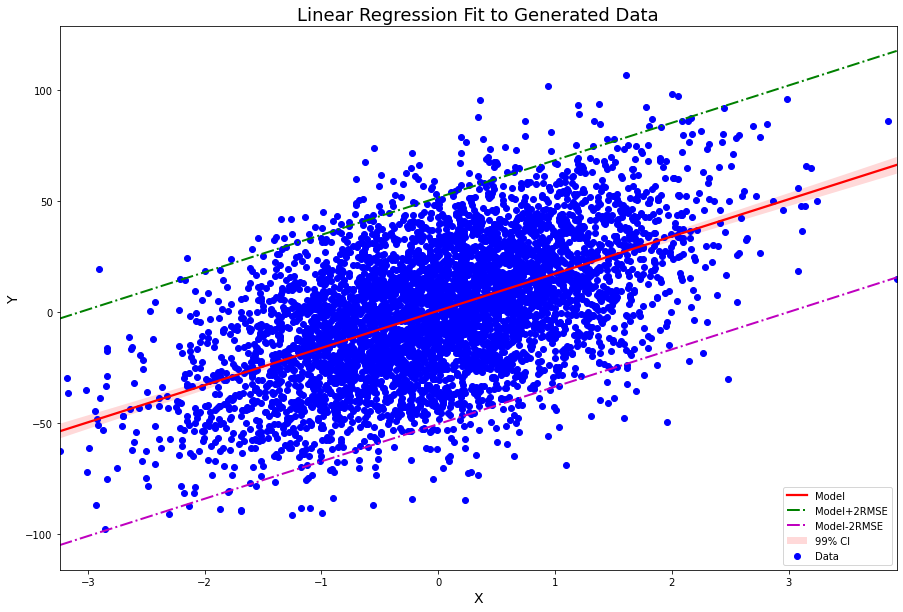

In [24]:
## plot the model against the dataset ##
xp = np.linspace(min(x),max(x),100)
plt.figure(figsize=(15,10))
sns.regplot(data=pd.DataFrame(data,columns=['x','y']),x='x',y='y',ci=99,scatter=False,color='r')
plt.scatter(x=data[:,0],y=data[:,1],color='b')
plt.plot(xp,np.mean(coef)*xp+np.mean(intrs)+2*np.mean(np.sqrt(mses)),'-.g',linewidth=2)
plt.plot(xp,np.mean(coef)*xp+np.mean(intrs)-2*np.mean(np.sqrt(mses)),'-.m',linewidth=2)
plt.title('Linear Regression Fit to Generated Data', fontsize=18)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend(['Model','Model+2RMSE','Model-2RMSE','99% CI','Data'],loc='lower right')
plt.show()